# Hands-On Anomaly Detection: Server Performance Analysis

- **Hands-on**
  - This notebook provides a challenge lab for anomaly detection learners.
  - Refer to the [document here](./30-anomaly_detection_intro.md) for background.
  - See the [Jupyter notebook](./35-anomaly_detection_demo.ipynb) for a practical demo.
- **Challenge Objective:**
  - Identify anomalies in the provided server performance dataset.
  - Propose one or more anomaly detection approaches.
  - Clearly describe your solution: design, architecture, and reasoning.
- **Notebook Sections:**
  - `Dataset Generation:` Create a dataset with server metrics like CPU, memory, and network traffic.
  - `Visual Inspection:` Check for obvious anomalies.
  - `Statistical Analysis:` _(Comparison)_ Apply statistical techniques for anomaly detection.
  - `Machine Learning:` _(Comparison)_ Implement an Isolation Forest algorithm.


## Dataset Generation

- In this section, you'll generate a synthetic dataset simulating server performance logs. This data will include:
  - `Timestamps`: Hourly intervals over three days, starting from '2023-10-27'
  - `CPU Usage`: Percentage of CPU utilization.
  - `Memory Usage`: Percentage of memory utilization.
  - `Network Traffic`: Network activity in arbitrary units.
- You will also have control over the severity of the anomalies and the number of anomalies using some parameters that you can modify to see how your generated dataset changes.
- Adjust these parameters and explore how these affect your final data and the ability to detect anomalies.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

def generate_server_logs(num_hours=72, base_cpu=30, base_memory=40, base_network=50, anomaly_level='mild', num_anomalies = 5, seed=42):
    """Generates a synthetic dataset of server performance logs with optional anomalies.

    Args:
        num_hours (int): The total number of hours for the simulation.
        base_cpu (int): The baseline CPU usage percentage.
        base_memory (int): The baseline memory usage percentage.
        base_network (int): The baseline network traffic (arbitrary units).
        anomaly_level (str): 'mild' or 'extreme', determines the magnitude of anomalies.
        num_anomalies (int): Number of anomalies to introduce
        seed (int): A random seed for reproducible results.

    Returns:
        pandas.DataFrame: A DataFrame with server performance data (timestamps, CPU, memory, network).
    """
    # Set a random seed for reproducibility, to ensure consistent data when you run this code again.
    np.random.seed(seed)

    # Create a time series index with hourly intervals.
    time = pd.date_range(start='2023-11-01', periods=num_hours, freq='h')

    # Generate baseline server metrics with random fluctuations using a normal distribution.
    # The mean is set to base_cpu, base_memory, and base_network respectively and the standard deviation is set to 3, 4 and 6.
    cpu_usage = base_cpu + np.random.normal(0, 3, num_hours)
    memory_usage = base_memory + np.random.normal(0, 4, num_hours)
    network_traffic = base_network + np.random.normal(0, 6, num_hours)

    # Introduce very obvious spikes in page views to simulate significant anomalies.
    # These spikes are designed to be easily noticeable in a plot of the data.
    anomaly_multiplier = 2 if anomaly_level == 'extreme' else 1.3
    # loop through a number of times and introduce anomalies in random places
    for i in range(num_anomalies):
      anomaly_hour = np.random.randint(10, num_hours - 10) # ensure the anomalies are not in the first or last 10 hrs to allow some room for the moving average calculation
      anomaly_duration = np.random.randint(1, 4) # pick a random duration between 1 and 3 hrs
      # apply multiplier to create the anomaly
      cpu_usage[anomaly_hour:anomaly_hour+anomaly_duration] *= anomaly_multiplier
      memory_usage[anomaly_hour:anomaly_hour+anomaly_duration] *= anomaly_multiplier
      network_traffic[anomaly_hour:anomaly_hour+anomaly_duration] *= anomaly_multiplier/1.5

    # Create a Pandas DataFrame to store the timestamp and metric data.
    df = pd.DataFrame({'Timestamp': time, 'CPU Usage': cpu_usage, 'Memory Usage': memory_usage, 'Network Traffic': network_traffic})

    # Set the 'Timestamp' column as the index of the DataFrame, so that it can be read as a time series.
    df.set_index('Timestamp', inplace=True)

    print("Dataset generated successfully.")
    return df

# Generate the dataset (user can modify the parameters)
data = generate_server_logs(num_hours=72, base_cpu=40, base_memory=50, base_network=60, anomaly_level='mild', num_anomalies=5, seed=42)

print(data.head())

Dataset generated successfully.
                     CPU Usage  Memory Usage  Network Traffic
Timestamp                                                    
2023-11-01 00:00:00  41.490142     49.856696        61.559297
2023-11-01 01:00:00  39.585207     56.258575        64.690937
2023-11-01 02:00:00  41.943066     39.521020        52.578296
2023-11-01 03:00:00  44.569090     53.287610        52.077260
2023-11-01 04:00:00  39.297540     50.348188        63.131649


## Simple Plot: Visual Inspection

- Here, you'll plot the raw server performance data, i.e., "CPU Usage", "Memory Usage" and "Network Traffic" over time.
- The aim here is to check if drastic deviations in the data are visible to the naked eye.
- The suitability of anomaly detection methods depends on the magnitude of the anomaly. If the deviation is drastic enough, then complex methods may be un-necessary.
- The exercise will show that while certain anomalies are readily apparent, other more subtle anomalies are difficult to discern from a simple plot.


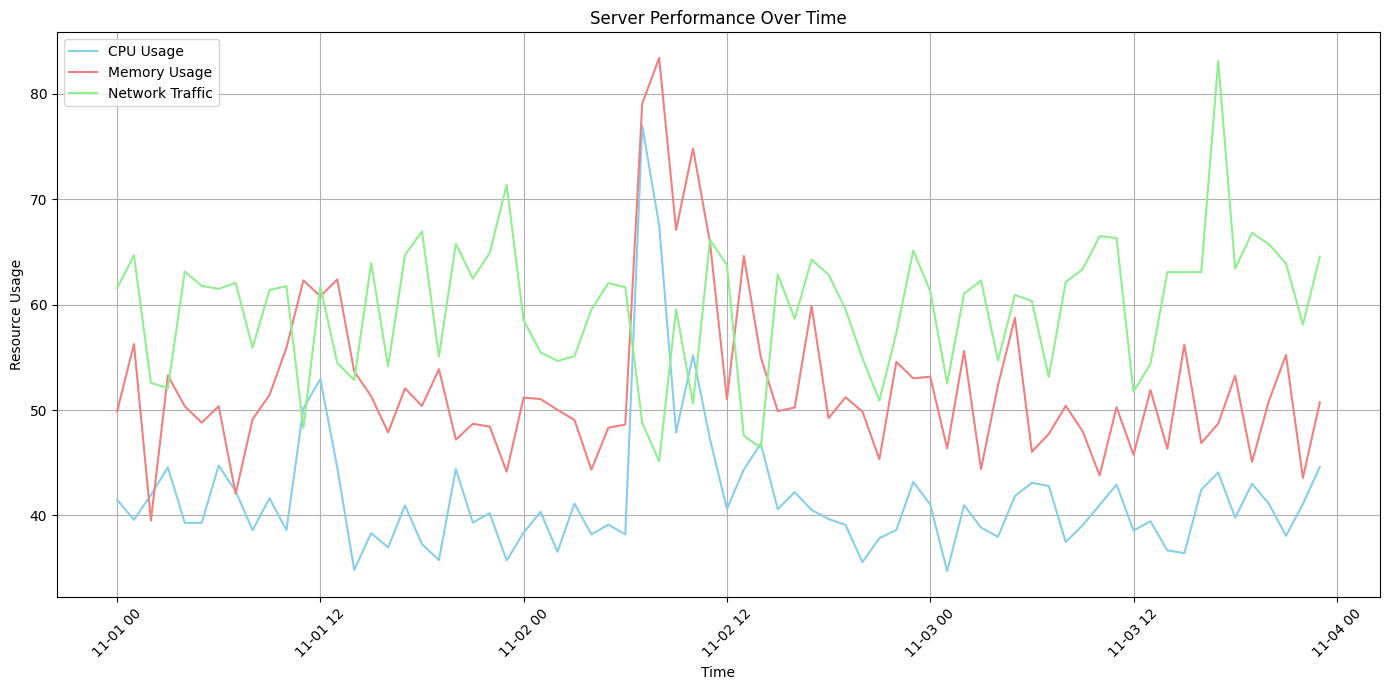

Simple plot of raw data generated. Notice how difficult it is to definitively identify anomalies just by looking at this plot.


In [2]:
def plot_server_logs(df):
    """
    Generates a simple line plot of server logs with 'CPU Usage', 'Memory Usage', and 'Network Traffic'.

    Args:
        df (pandas.DataFrame): DataFrame containing server log data.
    """
    # Create a new figure and a set of subplots. figsize=(width, height) sets the size of the plot in inches.
    plt.figure(figsize=(14, 7))

    # Plot each metric against the timestamps, creating a line plot
    plt.plot(df.index, df['CPU Usage'], label='CPU Usage', color='skyblue')
    plt.plot(df.index, df['Memory Usage'], label='Memory Usage', color='lightcoral')
    plt.plot(df.index, df['Network Traffic'], label='Network Traffic', color='lightgreen')

    # Set the title of the plot, the x-axis and y-axis
    plt.title('Server Performance Over Time')
    plt.xlabel('Time')
    plt.ylabel('Resource Usage')

    # Display the legend to identify the different metrics.
    plt.legend()

    # Add a grid to the plot for better readability.
    plt.grid(True)

     # Rotate the x-axis labels for better readability, especially when there are many timestamps.
    plt.xticks(rotation=45)

    # Adjust the plot layout to provide sufficient spacing around the plot elements, preventing labels from overlapping.
    plt.tight_layout()

    # Display the plot
    plt.show()
    print("Simple plot of raw data generated. Notice how difficult it is to definitively identify anomalies just by looking at this plot.")

# Plot the raw data to visually identify anomalies
plot_server_logs(data.copy())

## Statistical Anomaly Detection: Identifying Outliers

- This optional section demonstrates statistical anomaly detection using moving averages and standard deviations.
- It is provided to compare the results of your solution, or as a guide if your chosen approach didn't work.
- **Explanation of Statistical Method Code**
  - `Moving Average`: Calculated over a 3-hour window to smooth data.
  - `Standard Deviation`: Used with moving average to create anomaly detection bounds.
  - `Plot`: Displays the raw data, moving average, bounds, and anomalies.


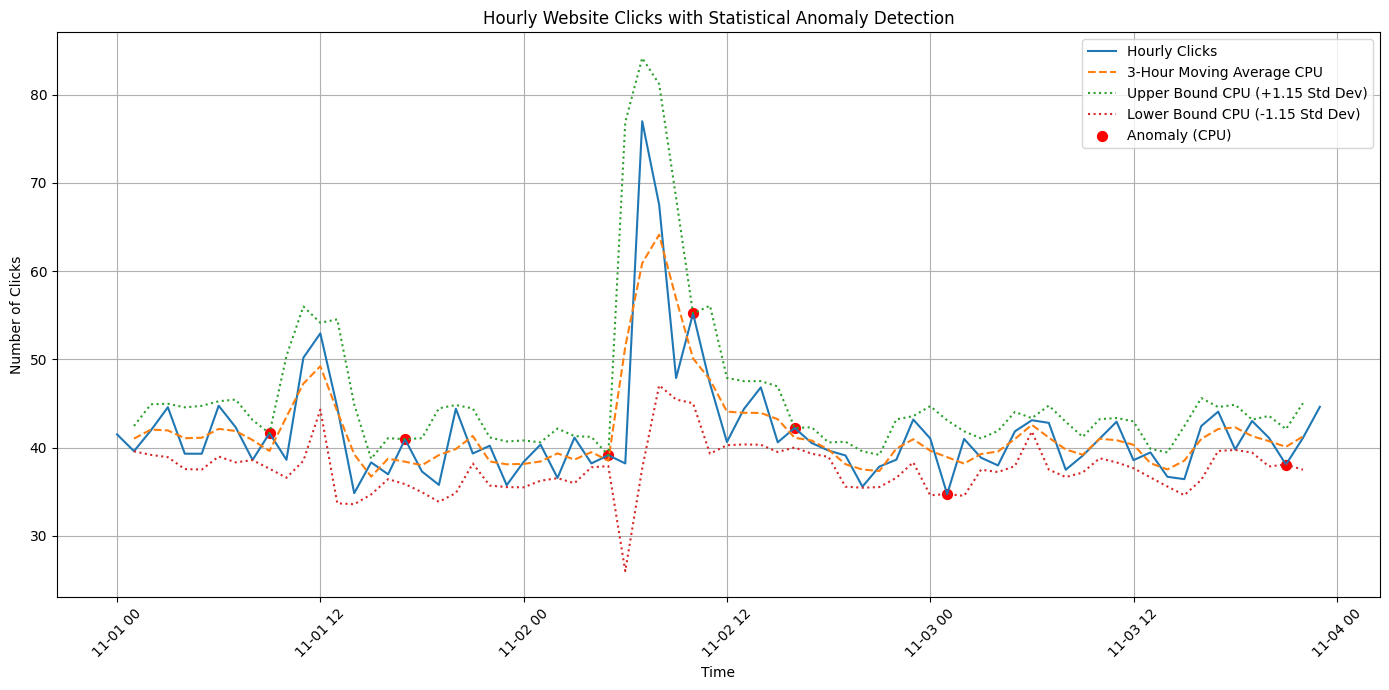

In [3]:
def statistical_anomaly_detection(df, window_size=3, deviation_factor=1.15):
    """
    Calculates moving average, standard deviation, and detects anomalies based on bounds.

    Args:
        df (pandas.DataFrame): DataFrame containing time-series data.
        window_size (int): Size of the rolling window.
        deviation_factor (float): Multiplier for standard deviation to define bounds.

    Returns:
        pandas.DataFrame: DataFrame with added columns for moving average, std dev, upper bound, lower bound, anomaly.
    """

    # Compute the 3-hour moving averages for each of the metrics to smooth out the fluctuations
    df['Moving Average CPU'] = df['CPU Usage'].rolling(window=window_size, center=True).mean()
    df['Moving Average Memory'] = df['Memory Usage'].rolling(window=window_size, center=True).mean()
    df['Moving Average Network'] = df['Network Traffic'].rolling(window=window_size, center=True).mean()

    # Compute the standard deviation of the metrics over the same window to identify the variance
    df['Std Dev CPU'] = df['CPU Usage'].rolling(window=window_size, center=True).std()
    df['Std Dev Memory'] = df['Memory Usage'].rolling(window=window_size, center=True).std()
    df['Std Dev Network'] = df['Network Traffic'].rolling(window=window_size, center=True).std()

    # Compute the upper and lower bounds for anomaly detection using the standard deviation multiplied by the deviation_factor
    df['Upper Bound CPU'] = df['Moving Average CPU'] + deviation_factor * df['Std Dev CPU']
    df['Lower Bound CPU'] = df['Moving Average CPU'] - deviation_factor * df['Std Dev CPU']

    df['Upper Bound Memory'] = df['Moving Average Memory'] + deviation_factor * df['Std Dev Memory']
    df['Lower Bound Memory'] = df['Moving Average Memory'] - deviation_factor * df['Std Dev Memory']

    df['Upper Bound Network'] = df['Moving Average Network'] + deviation_factor * df['Std Dev Network']
    df['Lower Bound Network'] = df['Moving Average Network'] - deviation_factor * df['Std Dev Network']

    # Mark as anomalous if a data point lies outside of these bounds
    df['Anomaly CPU'] = (df['CPU Usage'] > df['Upper Bound CPU']) | (df['CPU Usage'] < df['Lower Bound CPU'])
    df['Anomaly Memory'] = (df['Memory Usage'] > df['Upper Bound Memory']) | (df['Memory Usage'] < df['Lower Bound Memory'])
    df['Anomaly Network'] = (df['Network Traffic'] > df['Upper Bound Network']) | (df['Network Traffic'] < df['Lower Bound Network'])

    return df

def plot_statistical_anomalies(df):
    """Plots the data and highlights anomalies using statistical measures.

    Args:
        df (pandas.DataFrame): DataFrame containing the hourly clicks data with
                             moving average, standard deviation, and anomaly information.
    """

    plt.figure(figsize=(14, 7)) # Set the size of the plot

    # plot the raw click data
    plt.plot(df.index, df['CPU Usage'], label='Hourly Clicks')

    # Plot the moving average to visualize the overall trend
    plt.plot(df.index, df['Moving Average CPU'], label='3-Hour Moving Average CPU', linestyle='--')

    # Plot the upper and lower bound for anomaly detection using the standard deviations calculated
    plt.plot(df.index, df['Upper Bound CPU'], label=f'Upper Bound CPU (+1.15 Std Dev)', linestyle=':')
    plt.plot(df.index, df['Lower Bound CPU'], label=f'Lower Bound CPU (-1.15 Std Dev)', linestyle=':')

    # plot the actual anomalies as red circles
    plt.scatter(df[df['Anomaly CPU']].index, df[df['Anomaly CPU']]['CPU Usage'], color='red', label='Anomaly (CPU)', s=50)

    plt.title('Hourly Website Clicks with Statistical Anomaly Detection')
    plt.xlabel('Time')
    plt.ylabel('Number of Clicks')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Perform statistical anomaly detection and plot anomalies
data_stat = statistical_anomaly_detection(data.copy(), window_size=3, deviation_factor=1.15)
plot_statistical_anomalies(data_stat.copy()) # passing a copy here

## Machine Learning Anomaly Detection

- This optional section demonstrates ML-based anomaly detection using the Isolation Forest algorithm.
- It is provided to compare the results of your solution, or as a guide if your chosen approach didn't work.
- **Explanation of AI/ML Method Code**
  - `IsolationForest`: Used to learn data patterns and identify outliers.
  - `Data Preparation`: All numerical columns are used for training.
  - `Model Configuration`:
    - `n_estimators` is the number of trees.
    - `contamination` is the assumed proportion of outliers.
  - `Anomaly Scores`: Model calculates a score for each data point.
  - `Plot`: Shows raw data and anomalies identified by the algorithm.


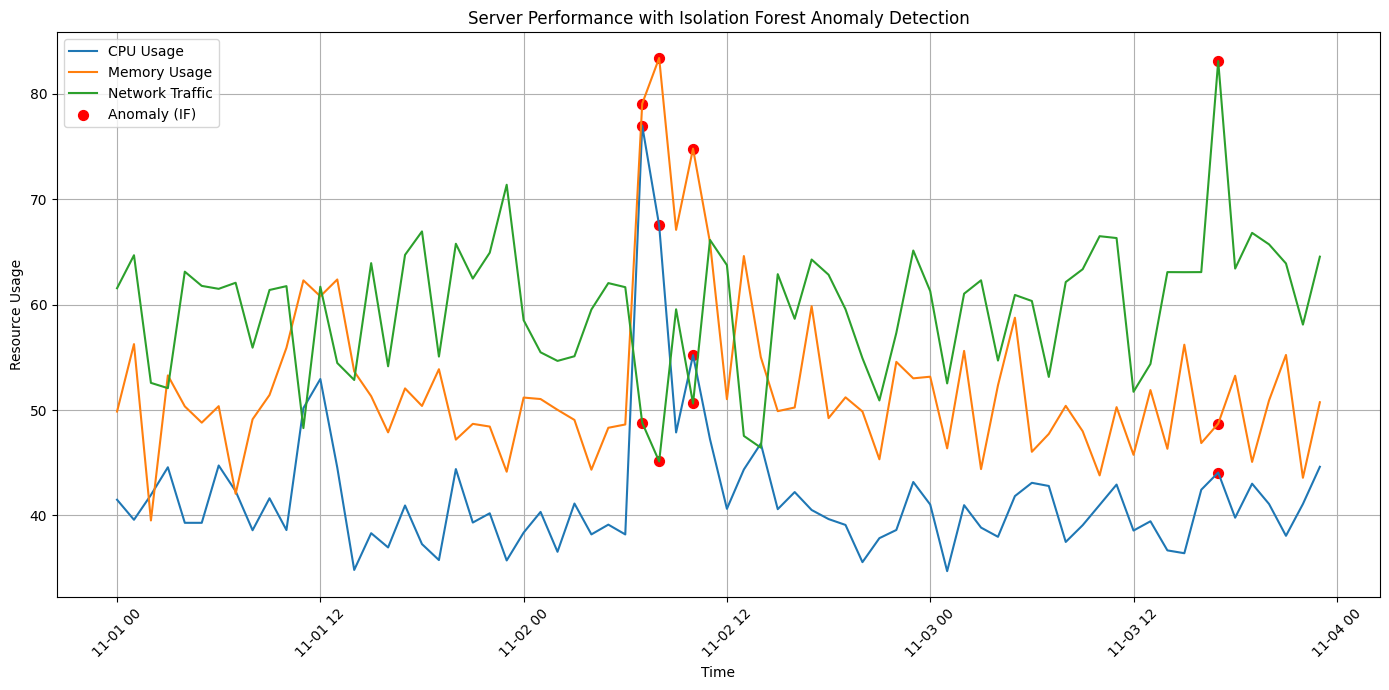

In [4]:
def isolation_forest_anomaly_detection(df_original, contamination=0.05, random_state=42):
    """
    Trains an Isolation Forest model and predicts anomalies.

    Args:
        df_original (pandas.DataFrame): DataFrame containing features to detect anomalies.
        contamination (float): The proportion of outliers in the dataset.
        random_state (int): Random seed to make results reproducible.

    Returns:
        pandas.DataFrame: DataFrame with added columns for Isolation Forest anomaly scores and labels.
    """
    # Make a copy so that we don't modify the original dataset
    df = df_original.copy()

    # Select all numerical columns for training the Isolation Forest Model
    X = df.select_dtypes(include=np.number)

    # Initialize the Isolation Forest model with specific parameters.
    model = IsolationForest(n_estimators=100, contamination=contamination, random_state=random_state)

    # Train the model
    model.fit(X)

    # Predict the anomalies, with a value of -1 signifying an anomaly
    df['Anomaly_IF'] = model.predict(X)

    # Create a boolean for the predicted anomalies. True indicates it is an anomaly
    df['Anomaly_IF_Boolean'] = df['Anomaly_IF'] == -1

    return df

def plot_isolation_forest_anomalies(df):
    """Plots the data and highlights anomalies using the Isolation Forest Algorithm.

    Args:
        df (pandas.DataFrame): DataFrame containing the hourly clicks data with
                             Isolation Forest anomaly labels.
    """

    plt.figure(figsize=(14, 7)) # Set the size of the plot

    # Plot the raw click data
    plt.plot(df.index, df['CPU Usage'], label='CPU Usage')
    plt.plot(df.index, df['Memory Usage'], label='Memory Usage')
    plt.plot(df.index, df['Network Traffic'], label='Network Traffic')

    # Plot the actual anomalies as red circles
    plt.scatter(df[df['Anomaly_IF_Boolean']].index, df[df['Anomaly_IF_Boolean']]['CPU Usage'], color='red', label='Anomaly (IF)', s=50)
    plt.scatter(df[df['Anomaly_IF_Boolean']].index, df[df['Anomaly_IF_Boolean']]['Memory Usage'], color='red', s=50)
    plt.scatter(df[df['Anomaly_IF_Boolean']].index, df[df['Anomaly_IF_Boolean']]['Network Traffic'], color='red', s=50)

    plt.title('Server Performance with Isolation Forest Anomaly Detection')
    plt.xlabel('Time')
    plt.ylabel('Resource Usage')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Run the Isolation Forest anomaly detection and plot the output
data_ml = isolation_forest_anomaly_detection(data.copy()) # passing a copy here
plot_isolation_forest_anomalies(data_ml)